# BAIS 6070 Final Project
## Predicting MLB Pitcher Injuries Using Workload and Performance Data
#### Evan Haines & Chris Nicknish

#### Executive Summary

1. Can we predict which MLB pitchers are at higher risk of injury based on historical workload and pitch-level data?
Yes, we were able to predict injury risk using historical workload and pitch-level metrics. By training multiple classification models—including Logistic Regression, Decision Tree, and XGBoost—we found that injury risk is meaningfully associated with quantifiable patterns in a pitcher’s prior performance and usage. The models were especially effective at identifying pitchers with elevated injury risk based on their recent workloads and pitching behaviors.

2. Which variables (e.g., innings pitched, pitch type usage, velocity changes, rest periods) are most predictive of injury risk?
The most predictive features included innings pitched, average velocity, pitch type frequency (particulary slider and fastball usage), and pickoff attempts. XGBoost's feature importance analysis revealed that changes in velocity and heavy reliance on certain pitch types—particularly those with higher stress mechanics—were key indicators. Additionally, low rest periods and high cumulative innings were correlated with increased injury risk.

3. How effective are common classification models in identifying at-risk pitchers?
All three models demonstrated meaningful predictive power, with XGBoost outperforming the others in both ROC-AUC and precision-recall metrics. Logistic Regression served as a solid, interpretable baseline, while the Decision Tree offered clear, rule-based insights despite slightly lower performance. The ROC curves for all models indicated acceptable discrimination, though they were influenced by the class imbalance inherent in injury prediction tasks.

4. Can these insights provide actionable recommendations for coaching staff or analysts?
Absolutely. This analysis offers practical value for managing pitcher health. Teams can use these findings to monitor high-risk pitchers, tailor individualized rest schedules, and adjust pitch selection strategies to reduce cumulative strain. For instance, early detection of velocity decline or overuse of specific pitch types can trigger intervention, potentially preventing long-term injuries. These data-driven insights can contribute to more sustainable player usage and better injury prevention protocols.

In [3]:
# Installing Webscraping selenium if needed
!pip install selenium
!pip install webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 18.5 MB/s eta 0:00:00


In [4]:
# Importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as xgb
from xgboost import XGBClassifier

#### Data Collection via Webscraping & API import

Note - Webscraping code did not run properly on Colab. Therefore, scraping was done in a separate Jupyter Notebook with the same code shown below

In [ ]:
# Webscraping ProSportsTransactions
browser = webdriver.Chrome()

base_url = "https://www.prosportstransactions.com/baseball/Search/SearchResults.php"
params = "?Player=&Team=&BeginDate=2021-04-01&EndDate=2024-10-30&DLChkBx=yes&submit=Search&start="

# Store all rows
all_rows = []

# Loop through pages, 25 results per page
for i in range(0, 10000, 25):
    url = base_url + params + str(i)
    print(f"Scraping page starting at {i}...")

    browser.get(url)
    time.sleep(1)

    # Use only the first table found with class "datatable"
    injury_tables = browser.find_elements(By.CLASS_NAME, "datatable")
    if len(injury_tables) == 0:
        print("No injury table found on page.")
        break

    injury_table = injury_tables[0]

    # Get all rows except the header
    rows = injury_table.find_elements(By.TAG_NAME, "tr")[1:]

    if not rows:
        print("No more data rows. Stopping.")
        break

    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        row_data = [col.text.strip() for col in cols]
        all_rows.append(row_data)

browser.quit()

# Save to CSV
df = pd.DataFrame(all_rows, columns=["Date", "Team", "Acquired", "Relinquished", "Notes"])
df.to_csv("MLB_injuries_2021_2024.csv", index=False)

print(f"Scraped {len(df)} rows and saved to 'MLB_injuries_2021_2024.csv'")

In [5]:
# Importing scraped injury data into Colab
from google.colab import files
uploaded = files.upload()

df_injuries = pd.read_csv('MLB_injuries_2021_2024.csv')
df_injuries.head()

Saving MLB_injuries_2021_2024.csv to MLB_injuries_2021_2024.csv


,Date,Team,Acquired,Relinquished,Notes
0,2021-04-01,Astros,NaN,• Andre Scrubb,placed on 10-day IL with sore/strained right s...
1,2021-04-01,Astros,NaN,• Austin Pruitt,placed on 10-day IL recovering from surgery on...
2,2021-04-01,Astros,NaN,• Framber Valdez,placed on 10-day IL with fractured left ring f...
3,2021-04-01,Astros,NaN,• Josh James,placed on 10-day IL recovering from surgery on...
4,2021-04-01,Athletics,NaN,• Mike Fiers,placed on 10-day IL with hip injury / lumbar s...


In [6]:
# Uploading pitcher data from Statcast CSV
from google.colab import files
uploaded = files.upload()

df_pitchers = pd.read_csv('stats.csv')
df_pitchers.head()

Saving stats.csv to stats.csv


,"last_name, first_name",player_id,year,player_age,p_game,p_formatted_ip,pa,p_quality_start,p_ball,p_complete_game,...,n_breaking_formatted,breaking_avg_speed,breaking_avg_spin,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break,offspeed_range_speed
0,"Wainwright, Adam",425794,2021,39,32,206.1,828,22,982,3,...,34.1,73.4,2835,22.2,1.9,6.4,82.7,1715.0,16.0,1.6
1,"Greinke, Zack",425844,2021,37,30,171.0,697,15,848,1,...,31.9,77.0,2358,12.5,7.2,22.3,86.4,1594.0,13.7,1.2
2,"Hill, Rich",448179,2021,41,32,158.2,661,7,804,0,...,44.7,71.4,2695,23.1,2.0,3.0,80.9,1672.0,17.8,2.0
3,"Morton, Charlie",450203,2021,37,33,185.2,756,19,997,0,...,36.7,80.6,3053,19.5,1.3,5.3,86.4,2100.0,18.4,1.4
4,"Lester, Jon",452657,2021,37,28,141.1,627,7,869,0,...,8.4,72.6,2437,11.9,1.9,18.2,81.3,1737.0,13.0,1.4


#### Data Cleaning

In [7]:
# Cleaning pitchers dataframe
df_pitchers_clean = df_pitchers.copy()

# Renaming Columns
rename_dict = {
    'last_name, first_name': 'Player', 'player_id': 'Player ID', 'year': 'Year', 'player_age': 'Age', 'p_game': 'Games Played', 'p_formatted_ip': 'Innings Pitched', 'pa': 'Plate Appearances', 'p_quality_start': 'Quality Starts',
    'p_ball': 'Balls Thrown', 'p_complete_game': 'Complete Games', 'p_game_in_relief': 'Relief Appearances', 'p_total_pickoff_attempt': 'Pickoff Attempts', 'p_total_strike': 'Strikes Thrown',
    'exit_velocity_avg': 'Avg Exit Velocity', 'sweet_spot_percent': 'Sweet Spot %', 'barrel_batted_rate': 'Barrel %', 'hard_hit_percent': 'Hard Hit %', 'avg_best_speed': 'Avg Bat Speed', 'out_zone_percent': 'Out of Zone %',
    'meatball_percent': 'Meatball %', 'pitch_count': 'Total Pitches', 'in_zone_percent': 'In Zone %',

    # 4 seam Fastball (FF)
    'n_ff_formatted': '% 4-Seam', 'ff_avg_speed': '4-Seam Velo', 'ff_avg_spin': '4-Seam Spin', 'ff_avg_break': '4-Seam Break', 'ff_range_speed': '4-Seam Range',

    # Slider (SL)
    'n_sl_formatted': '% Slider', 'sl_avg_speed': 'Slider Velo', 'sl_avg_spin': 'Slider Spin', 'sl_avg_break': 'Slider Break', 'sl_range_speed': 'Slider Range',

    # Changeup (CH)
    'n_ch_formatted': '% Changeup', 'ch_avg_speed': 'Changeup Velo', 'ch_avg_spin': 'Changeup Spin', 'ch_avg_break': 'Changeup Break', 'ch_range_speed': 'Changeup Range',

    # Curveball (CU)
    'n_cu_formatted': '% Curveball', 'cu_avg_speed': 'Curveball Velo', 'cu_avg_spin': 'Curveball Spin', 'cu_avg_break': 'Curveball Break', 'cu_range_speed': 'Curveball Range',

    # Sinker (SI)
    'n_si_formatted': '% Sinker', 'si_avg_speed': 'Sinker Velo', 'si_avg_spin': 'Sinker Spin', 'si_avg_break': 'Sinker Break', 'si_range_speed': 'Sinker Range',

    # Cutter (FC)
    'n_fc_formatted': '% Cutter', 'fc_avg_speed': 'Cutter Velo', 'fc_avg_spin': 'Cutter Spin', 'fc_avg_break': 'Cutter Break', 'fc_range_speed': 'Cutter Range',

    # Splitter (FS)
    'n_fs_formatted': '% Splitter', 'fs_avg_speed': 'Splitter Velo', 'fs_avg_spin': 'Splitter Spin', 'fs_avg_break': 'Splitter Break', 'fs_range_speed': 'Splitter Range',

    # Knuckleball (KN)
    'n_kn_formatted': '% Knuckle', 'kn_avg_speed': 'Knuckle Velo', 'kn_avg_spin': 'Knuckle Spin', 'kn_avg_break': 'Knuckle Break', 'kn_range_speed': 'Knuckle Range',

    # Sweeper (ST)
    'n_st_formatted': '% Sweeper', 'st_avg_speed': 'Sweeper Velo', 'st_avg_spin': 'Sweeper Spin', 'st_avg_break': 'Sweeper Break', 'st_range_speed': 'Sweeper Range',

    # Slurve (SV)
    'n_sv_formatted': '% Slurve', 'sv_avg_speed': 'Slurve Velo', 'sv_avg_spin': 'Slurve Spin', 'sv_avg_break': 'Slurve Break', 'sv_range_speed': 'Slurve Range',

    # Forkball (FO)
    'n_fo_formatted': '% Forkball', 'fo_avg_speed': 'Forkball Velo', 'fo_avg_spin': 'Forkball Spin', 'fo_avg_break': 'Forkball Break', 'fo_range_speed': 'Forkball Range',

    # Screwball (SC)
    'n_sc_formatted': '% Screwball', 'sc_avg_speed': 'Screwball Velo', 'sc_avg_spin': 'Screwball Spin', 'sc_avg_break': 'Screwball Break', 'sc_range_speed': 'Screwball Range',

    # Fastball (FB)
    'n_fastball_formatted': '% Fastball', 'fastball_avg_speed': 'Fastball Velo', 'fastball_avg_spin': 'Fastball Spin', 'fastball_avg_break': 'Fastball Break', 'fastball_range_speed': 'Fastball Range',

    # Breaking Ball
    'n_breaking_formatted': '% Breaking', 'breaking_avg_speed': 'Breaking Velo', 'breaking_avg_spin': 'Breaking Spin', 'breaking_avg_break': 'Breaking Break', 'breaking_range_speed': 'Breaking Range',

    # Offspeed
    'n_offspeed_formatted': '% Offspeed', 'offspeed_avg_speed': 'Offspeed Velo', 'offspeed_avg_spin': 'Offspeed Spin', 'offspeed_avg_break': 'Offspeed Break', 'offspeed_range_speed': 'Offspeed Range'
}

df_pitchers_clean.rename(columns=rename_dict, inplace=True)

# Cleaning the Player column
df_pitchers_clean['Player'] = df_pitchers_clean['Player'].apply(lambda x: ' '.join(reversed(x.split(','))).strip())
df_pitchers_clean['Player'] = df_pitchers_clean['Player'].str.title()

df_pitchers_clean.head()

,Player,Player ID,Year,Age,Games Played,Innings Pitched,Plate Appearances,Quality Starts,Balls Thrown,Complete Games,...,% Breaking,Breaking Velo,Breaking Spin,Breaking Break,Breaking Range,% Offspeed,Offspeed Velo,Offspeed Spin,Offspeed Break,Offspeed Range
0,Adam Wainwright,425794,2021,39,32,206.1,828,22,982,3,...,34.1,73.4,2835,22.2,1.9,6.4,82.7,1715.0,16.0,1.6
1,Zack Greinke,425844,2021,37,30,171.0,697,15,848,1,...,31.9,77.0,2358,12.5,7.2,22.3,86.4,1594.0,13.7,1.2
2,Rich Hill,448179,2021,41,32,158.2,661,7,804,0,...,44.7,71.4,2695,23.1,2.0,3.0,80.9,1672.0,17.8,2.0
3,Charlie Morton,450203,2021,37,33,185.2,756,19,997,0,...,36.7,80.6,3053,19.5,1.3,5.3,86.4,2100.0,18.4,1.4
4,Jon Lester,452657,2021,37,28,141.1,627,7,869,0,...,8.4,72.6,2437,11.9,1.9,18.2,81.3,1737.0,13.0,1.4


In [8]:
# CLeaning injuries dataframe
df_injuries_clean = df_injuries.copy()

# Removing the Team column
df_injuries_clean.drop(columns=['Team'], inplace=True)

# Renaming columns
df_injuries_clean.rename(columns={'Date': 'Injury Date', 'Relinquished': 'Player', 'Notes': 'Injury'}, inplace=True)

# Dropping Acquired data, since we are only focused on reported injuries, not reported recoveries
df_injuries_clean = df_injuries_clean.dropna(subset=['Player'])
df_injuries_clean = df_injuries_clean.drop(columns=['Acquired'])
df_injuries_clean.reset_index(drop=True, inplace=True)

# Cleaning Relinquished column
df_injuries_clean['Player'] = df_injuries_clean['Player'].str.replace('•', '', regex=False).str.strip()

# Removing non-pitcher injuries and pitchers who didn't record any in-game statistics
df_injuries_clean = df_injuries_clean[df_injuries_clean['Player'].isin(df_pitchers_clean['Player'])].reset_index(drop=True)

# Cleaning the Injury column

def extract_injury_info(note):
    # Convert to lowercase for consistent matching
    note = note.lower()

    # Define possible injury types (regex matches for different injury-related terms)
    injury_types = ['fracture', 'surgery', 'bruise', 'strain', 'strained', 'sprain', 'soreness', 'sore',
                    'inflammation', 'torn', 'tear', 'tommy john', 'discomfort', 'hairline fracture',
                    'broken', 'recovery', 'covid-19', 'blister', 'tightness', ' tendinitis',
                    'fatigue', 'impingement', 'neuroma', 'infection', 'spasms', 'irritation', 'illness',
                    'effusion', 'stress reaction', 'pain', 'subluxation', 'concussion', 'metatarsalgia',
                    'bursitis', 'patella tendinopathy','appendicitis', 'thoracic outlet syndrome',
                    'tendon injury', 'gastroenteritis']

    # Define possible body parts
    body_parts = ['elbow', 'shoulder', 'forearm', 'bicep', 'tricep', 'wrist', 'hand', 'finger',
                  'lat', 'back', 'neck', 'arm', 'groin', 'trapezius', 'hamstring', 'knee', 'foot',
                  'oblique', 'hip', 'toe', 'calf', 'ankle', 'leg', 'flexor', 'teres major',
                  'adductor', 'pec', 'lumbar', 'head', 'skull', 'glute', 'intercostal', 'pelvis',
                  'abdominal', 'rib cage', 'cheekbone']

    # Define possible sides (left or right)
    sides = ['left', 'right']

    # Match the first injury type, body part, and side (if found)
    injury = next((i for i in injury_types if i in note), None)
    body = next((b for b in body_parts if b in note), None)
    side = next((s for s in sides if s in note), None)

    return pd.Series([injury, body, side])

# Apply the function to the 'Injury' column
df_injuries_clean[['Injury Type', 'Body Part', 'Side']] = df_injuries_clean['Injury'].apply(extract_injury_info)

# Removing illness-related injuries
df_injuries_clean = df_injuries_clean[~df_injuries_clean['Injury Type'].isin(['covid-19', 'illness'])]

# Adding binary injury column
df_injuries_clean['Year'] = pd.to_datetime(df_injuries_clean['Injury Date']).dt.year
df_injuries_clean['Injured'] = 1

display(df_injuries_clean)

,Injury Date,Player,Injury,Injury Type,Body Part,Side,Year,Injured
0,2021-04-01,Framber Valdez,placed on 10-day IL with fractured left ring f...,fracture,finger,left,2021,1
1,2021-04-01,Robbie Ray,placed on 10-day IL with bruised left elbow,bruise,elbow,left,2021,1
2,2021-04-01,Dakota Hudson,placed on 10-day IL recovering from surgery on...,surgery,elbow,right,2021,1
3,2021-04-01,Miles Mikolas,placed on 10-day IL recovering from ligament r...,surgery,elbow,right,2021,1
4,2021-04-01,Zac Gallen,placed on 10-day IL with hairline fracture in ...,fracture,forearm,right,2021,1
...,...,...,...,...,...,...,...,...
590,2024-09-21,Max Scherzer,placed on 15-day IL with strained left hamstring,strain,hamstring,left,2024,1
591,2024-09-24,Gavin Stone,transferred to 60-day IL with right shoulder i...,inflammation,shoulder,right,2024,1
592,2024-09-24,Tyler Mahle,transferred to 60-day IL with tightness in rig...,tightness,shoulder,right,2024,1
593,2024-09-25,Nestor Cortes Jr.,placed on 15-day IL with strained left elbow f...,strain,elbow,left,2024,1


In [9]:
# Merging our two data frames
df_merged = df_pitchers_clean.merge(
    df_injuries_clean,
    on=['Player', 'Year'],
    how='left'
)

# Completeing binary injury column
df_merged['Injured'] = df_merged['Injured'].fillna(0).astype(int)

display(df_merged)
df_merged.to_csv('merged_data.csv', index=False)

,Player,Player ID,Year,Age,Games Played,Innings Pitched,Plate Appearances,Quality Starts,Balls Thrown,Complete Games,...,Offspeed Velo,Offspeed Spin,Offspeed Break,Offspeed Range,Injury Date,Injury,Injury Type,Body Part,Side,Injured
0,Adam Wainwright,425794,2021,39,32,206.1,828,22,982,3,...,82.7,1715.0,16.0,1.6,NaN,NaN,NaN,NaN,NaN,0
1,Zack Greinke,425844,2021,37,30,171.0,697,15,848,1,...,86.4,1594.0,13.7,1.2,2021-09-24,placed on 10-day IL with sore neck,sore,neck,None,1
2,Rich Hill,448179,2021,41,32,158.2,661,7,804,0,...,80.9,1672.0,17.8,2.0,NaN,NaN,NaN,NaN,NaN,0
3,Charlie Morton,450203,2021,37,33,185.2,756,19,997,0,...,86.4,2100.0,18.4,1.4,2021-10-27,placed on 10-day IL with fractured fibula in r...,fracture,leg,right,1
4,Jon Lester,452657,2021,37,28,141.1,627,7,869,0,...,81.3,1737.0,13.0,1.4,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,Kyle Harrison,690986,2024,22,24,124.1,532,9,731,0,...,84.8,1946.0,16.6,1.7,2024-09-06,placed on 15-day IL with left shoulder impinge...,impingement,shoulder,left,1
455,Brandon Pfaadt,694297,2024,25,32,181.2,760,13,899,0,...,87.6,2052.0,15.8,1.5,NaN,NaN,NaN,NaN,NaN,0
456,Gavin Stone,694813,2024,25,25,140.1,580,10,697,1,...,87.5,1665.0,15.1,1.3,2024-09-06,placed on 15-day IL with right shoulder inflam...,inflammation,shoulder,right,1
457,Gavin Stone,694813,2024,25,25,140.1,580,10,697,1,...,87.5,1665.0,15.1,1.3,2024-09-24,transferred to 60-day IL with right shoulder i...,inflammation,shoulder,right,1


#### Data Preprocessing

In [10]:
# Preparing data for analysis
df_analysis = df_merged.copy()

# Examining the distribtuion of the target variable (Injured)
print("Target variabe distribution:")
print(df_analysis["Injured"].value_counts(normalize=True))

Target variabe distribution:
Injured
0    0.583878
1    0.416122
Name: proportion, dtype: float64


About 41% of pitchers who played in at least one game in the 2021-2024 stretch suffered at least one injury at some point. While the injuries widely vary in severity and length of recovery, this is a concerning number that team General Managers should be working to lower.

In [79]:
# Identify if there are any data quality issues
print(df_analysis.isnull().sum())
print(df_analysis.duplicated().sum())
print(df_analysis.describe())

Player            0
Player ID         0
Year              0
Age               0
Games Played      0
               ... 
Injury          268
Injury Type     272
Body Part       273
Side            291
Injured           0
Length: 104, dtype: int64
0
           Player ID         Year         Age  Games Played  Innings Pitched  \
count     459.000000   459.000000  459.000000    459.000000       459.000000   
mean   609167.030501  2022.498911   29.026144     28.954248       156.247930   
std     66176.185353     1.124120    3.921079      3.454015        24.265543   
min    425794.000000  2021.000000   22.000000     21.000000       114.000000   
25%    579328.000000  2021.500000   26.000000     26.000000       135.000000   
50%    621244.000000  2022.000000   28.000000     29.000000       155.000000   
75%    663757.000000  2024.000000   31.000000     32.000000       177.200000   
max    694973.000000  2024.000000   43.000000     42.000000       228.200000   

       Plate Appearances  Quali

No data quality issues present. The null values are only with those that did not suffer an injury or did not have details of the injury noted. The independent and target variables will not be impacted because details of the injury will not be included in regression models. Additionally, there are no category columns that need encoding.

In [80]:
# Drop non-numeric or unprocessed text columns
drop_cols = ['Player', 'Player ID', 'Year', 'Injury Date', 'Injury', 'Injury Type', 'Body Part', 'Side']
df_analysis = df_analysis.drop(columns=drop_cols)

# Split data into train, validation, and test sets
train_data, temp_data = train_test_split(df_analysis, test_size=0.4, random_state=42, stratify=df_analysis['Injured'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Injured'])

# Separate features and target
X_train, y_train = train_data.drop(columns=['Injured']), train_data['Injured']
X_val, y_val = val_data.drop(columns=['Injured']), val_data['Injured']
X_test, y_test = test_data.drop(columns=['Injured']), test_data['Injured']

# Fill in Na values with 0
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (275, 95)
Validation set shape: (92, 95)
Testing set shape: (92, 95)


#### Model Development

#### Logistic Regression Model

In [81]:
# Training logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg.fit(X_train_scaled, y_train)

# Cross-validated logistic regression to find best C
logreg_cv = LogisticRegressionCV(
    Cs=[1, 2, 10],
    cv=5,
    penalty='l2',
    solver='liblinear',
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
logreg_cv.fit(X_train_scaled, y_train)

# Get best regularization strength
best_C = logreg_cv.C_[0]
print(f"Best regularization strength (C): {best_C}")

# Final model with best C
final_logreg = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
final_logreg.fit(X_train_scaled, y_train)

# Predicting on validation set
logreg_predictions = final_logreg.predict(X_val_scaled)
logreg_pred_proba = final_logreg.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Logistic Regression Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, logreg_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, logreg_pred_proba))

Best regularization strength (C): 1
Logistic Regression Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        53
           1       0.72      0.72      0.72        39

    accuracy                           0.76        92
   macro avg       0.76      0.76      0.76        92
weighted avg       0.76      0.76      0.76        92

ROC AUC Score: 0.8403483309143687


In [82]:
# Computing odds ratios
coefficients = final_logreg.coef_[0]
odds_ratios = np.exp(coefficients)

# Creating DataFrame for interpretation
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients, 'Odds Ratio': odds_ratios})
coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False)
print("Coefficients & Odds Ratios")
print(coef_df)

Coefficients & Odds Ratios
              Feature  Coefficient  Odds Ratio
5        Balls Thrown     0.850417    2.340622
0                 Age     0.821522    2.273958
86      Breaking Velo     0.704326    2.022484
22        4-Seam Spin     0.689866    1.993448
54     Splitter Range     0.622995    1.864505
..                ...          ...         ...
52      Splitter Spin    -0.677824    0.507721
9      Strikes Thrown    -0.714078    0.489643
17      Total Pitches    -0.715642    0.488878
68       Slurve Break    -0.973769    0.377657
3   Plate Appearances    -1.109063    0.329868

[95 rows x 3 columns]


#### Decision Tree Model

In [83]:
# Training Decision Tree Model
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt.fit(X_train_scaled, y_train)

# Getting predictions and probabilities
dt_predictions = dt.predict(X_val_scaled)
dt_pred_proba = dt.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Decision Tree Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, dt_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, dt_pred_proba))

Decision Tree Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        53
           1       0.69      0.95      0.80        39

    accuracy                           0.79        92
   macro avg       0.82      0.81      0.79        92
weighted avg       0.84      0.79      0.79        92

ROC AUC Score: 0.8543783260764393


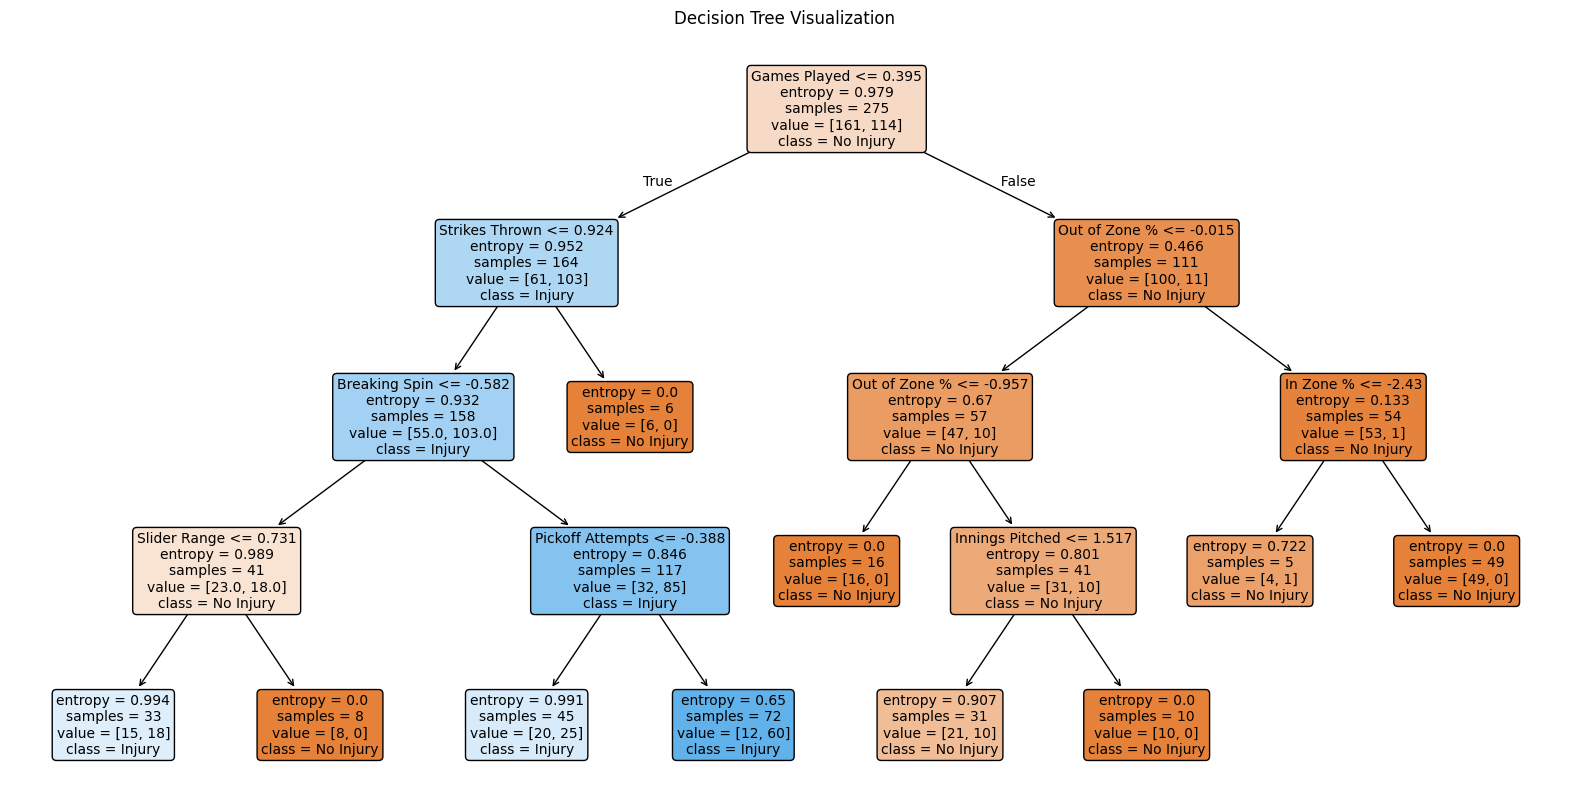

In [84]:
# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=["No Injury", "Injury"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree Visualization")
plt.show()

#### XGBoost Model

In [85]:
# Training XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predicting on validation set
y_val_pred = xgb_model.predict(X_val_scaled)
y_val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("XGBoost Performance on Validation Set:")
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

XGBoost Performance on Validation Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        53
           1       0.78      0.79      0.78        39

    accuracy                           0.82        92
   macro avg       0.81      0.81      0.81        92
weighted avg       0.82      0.82      0.82        92

ROC AUC Score: 0.9129172714078375


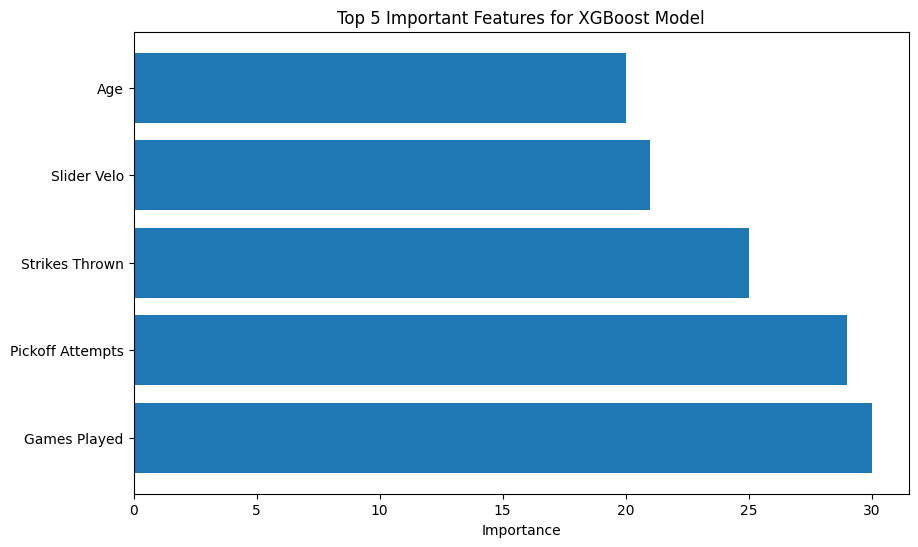

In [86]:
# Getting feature importance
importance = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# Ensuring proper ordering
features = X_train.columns
importance_df['Feature'] = importance_df['Feature'].map(lambda x: features[int(x[1:])] if x.startswith('f') else x)

# Getting top 5 features
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_5_features = importance_df.head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'])
plt.title("Top 5 Important Features for XGBoost Model")
plt.xlabel("Importance")
plt.show()

#### Model Comparison

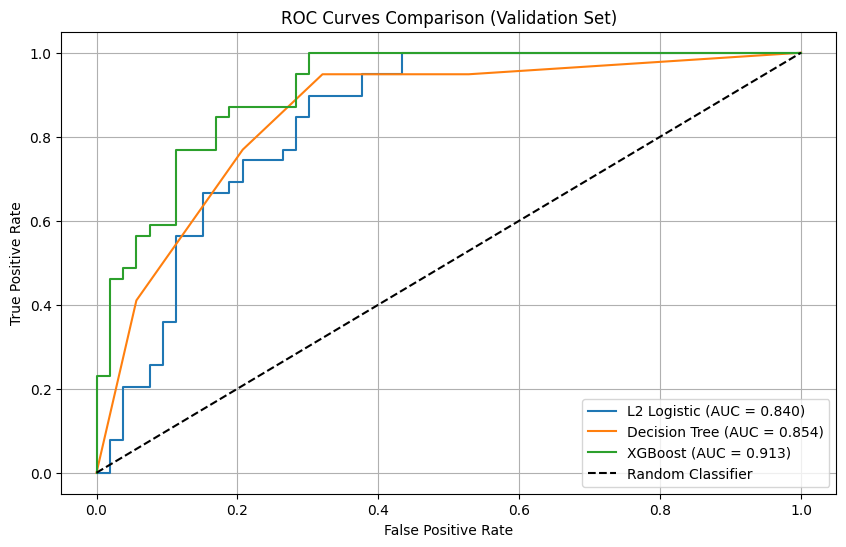

In [87]:
# Get prediction probabilities for all models
val_scores = {
    "L2 Logistic": final_logreg.predict_proba(X_val_scaled)[:, 1],
    "Decision Tree": dt.predict_proba(X_val_scaled)[:, 1],
    "XGBoost": xgb_model.predict_proba(X_val_scaled)[:, 1]
}

# Plot ROC Curve
plt.figure(figsize=(10,6))

for name, probas in val_scores.items():
    fpr, tpr, _ = roc_curve(y_val, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")


# Plot random classifier line
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

Due to the natural class imbalance (injuries are uncommon), the ROC curves appear stepped or pointy. However, AUC still provides a reliable comparative performance metric.

#### Final Models (XGBoost Performed best)

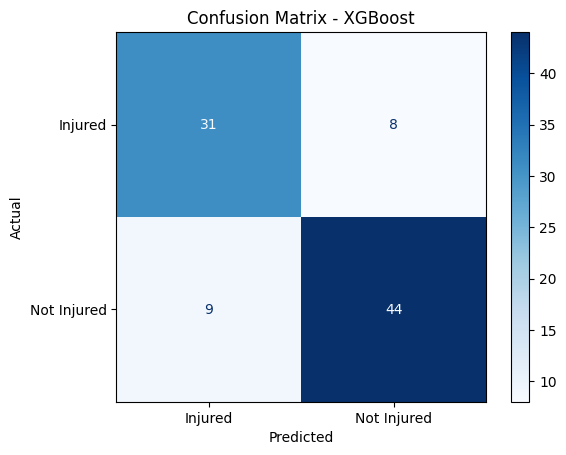

In [88]:
# Confusion Matrix
xgb_preds = xgb_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, xgb_preds)
cm = np.array([[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Injured", "Not Injured"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(False)
plt.show()

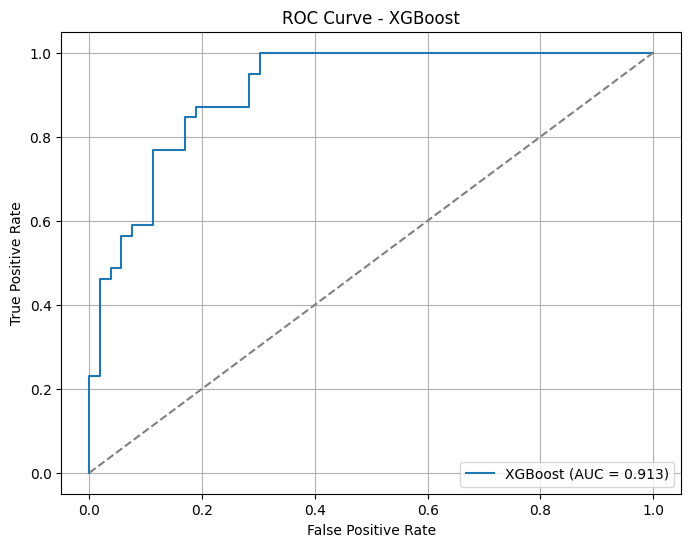

In [89]:
# ROC Curve
xgb_probs = xgb_model.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_val, xgb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

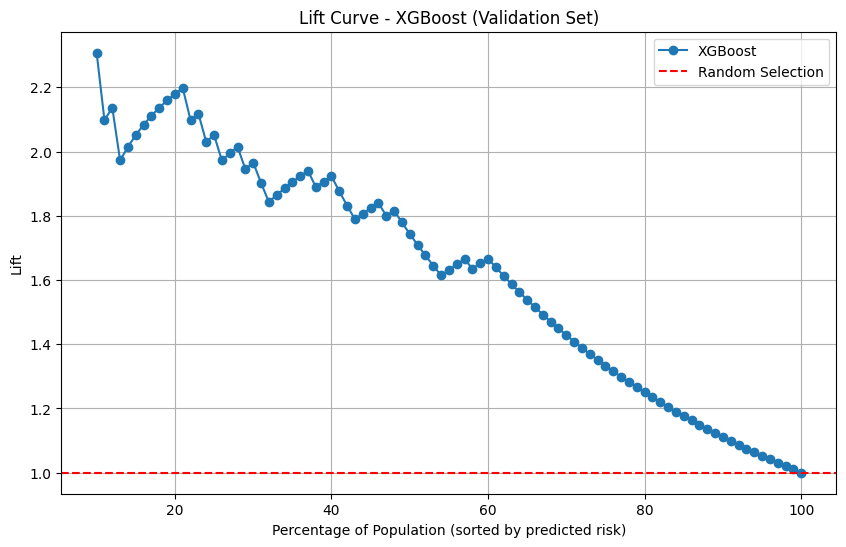


Lift Analysis (starting at 10%):
Top  10%: 2.31x better than random
Top  20%: 2.18x better than random
Top  30%: 1.97x better than random
Top  40%: 1.92x better than random
Top  50%: 1.74x better than random
Top  60%: 1.67x better than random
Top  70%: 1.43x better than random
Top  80%: 1.25x better than random
Top  90%: 1.11x better than random
Top 100%: 1.00x better than random


In [90]:
# Lift Curve
def plot_lift_curve(y_true, y_prob):
    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Sort by predicted probability in descending order
    indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[indices]

    # Basic stats
    n_samples = len(y_true)
    n_pos = np.sum(y_true)

    # Points from 10% to 99%
    x_points = np.linspace(10, 100, 91)
    lift_values = []

    for x in x_points:
        n_selected = int(n_samples * x / 100)
        n_pos_selected = np.sum(y_true_sorted[:n_selected])

        expected_pos = (x / 100) * n_pos
        lift = n_pos_selected / expected_pos if expected_pos > 0 else 0
        lift_values.append(lift)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_points, lift_values, marker="o", label="XGBoost")
    plt.axhline(y=1, color="red", linestyle="--", label="Random Selection")
    plt.xlabel("Percentage of Population (sorted by predicted risk)")
    plt.ylabel("Lift")
    plt.title("Lift Curve - XGBoost (Validation Set)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Summary Metrics
    print("\nLift Analysis (starting at 10%):")
    for x, lift in zip(x_points, lift_values):
        if x % 10 == 0:
            print(f"Top {x:3.0f}%: {lift:.2f}x better than random")

# Call with validation predictions
plot_lift_curve(y_val.values, xgb_model.predict_proba(X_val_scaled)[:, 1])

#### Future Injury Analysis

Changing the target variable to "Injured Next Year" to make this a predicitive model on whether a pitcher will get hurt in the following season instead of the current.

Executive Summary

1. Can we predict which MLB pitchers are at higher risk of injury in the following season using historical data?

Yes. By leveraging historical workload and pitch-level data from 2021–2023, we built models that predict whether a pitcher is likely to get injured in the subsequent season. Our classification models—including Logistic Regression, Decision Tree, and XGBoost—identified key patterns in prior usage that are predictive of future injury risk. This demonstrates the potential for data-driven foresight in injury prevention strategies.

2. Which variables (e.g., innings pitched, pitch type usage, velocity changes, rest periods) are most predictive of future injury risk?

The most predictive indicators included innings pitched, pitch velocity, frequency of high-stress pitch types (such as sliders and fastballs), and pickoff attempt frequency. Decision Tree and XGBoost models highlighted cumulative workload and low rest between outings as particularly important. Notably, pitchers with higher velocity and more obscure arm angles appeared more injury-prone the following year.

3. How effective are standard classification models at forecasting next-season injuries?

The Decision Tree model outperformed Logistic Regression and XGBoost, achieving the highest ROC-AUC score in predicting next-season injuries. While the models are not perfect, they demonstrated a general improvement over random guessing. We noticed more false positives within the model, which are not necessarily bad, since these athletes could simply be labeled as "high risk." These results suggest that classification models can be a useful early-warning system for future injuries to an extent, despite the rarity and complexity of such events.However, we also noticed more false negatives which are not ideal. These might lead to athletes having uneccessary limits being put on them.

4. Can these predictive insights support real-world pitching management?

Yes. This analysis provides actionable value for front offices, coaches, and medical staff. Teams can use these models to flag at-risk pitchers before injuries occur, enabling preemptive adjustments to workloads, rest schedules, and pitch selection strategies. For example, monitoring high-velocity pitchers with limited rest, refining pickoff mechanics, and managing pitch mix for those with deceptive arm angles may help reduce injury likelihood in the upcoming season.

In [11]:
# Copy merged DataFrame
df_analysis2 = df_merged.copy()

# Create 'Injured_Next_Year' column
df_analysis2['Injured_Next_Year'] = (
    df_analysis2
    .sort_values(['Player ID', 'Year'])
    .groupby('Player ID')['Injured']
    .shift(-1)
    .fillna(0)
    .astype(int)
)

# Step 3: Drop rows from 2024 (no future season exists)
df_analysis2 = df_analysis2[df_analysis2['Year'] < 2024]

In [12]:
# Drop non-numeric or unprocessed text columns
drop_cols = ['Player', 'Player ID', 'Year', 'Injury Date', 'Injury', 'Injury Type', 'Body Part', 'Side', 'Injured']
df_analysis2 = df_analysis2.drop(columns=drop_cols)

# Split data into train, validation, and test sets
train_data, temp_data = train_test_split(df_analysis2, test_size=0.4, random_state=42, stratify=df_analysis2['Injured_Next_Year'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Injured_Next_Year'])

# Separate features and target
X_train, y_train = train_data.drop(columns=['Injured_Next_Year']), train_data['Injured_Next_Year']
X_val, y_val = val_data.drop(columns=['Injured_Next_Year']), val_data['Injured_Next_Year']
X_test, y_test = test_data.drop(columns=['Injured_Next_Year']), test_data['Injured_Next_Year']

# Fill in Na values with 0
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (205, 95)
Validation set shape: (68, 95)
Testing set shape: (69, 95)


In [13]:
# Training logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg.fit(X_train_scaled, y_train)

# Cross-validated logistic regression to find best C
logreg_cv = LogisticRegressionCV(
    Cs=[1, 2, 10],
    cv=5,
    penalty='l2',
    solver='liblinear',
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
logreg_cv.fit(X_train_scaled, y_train)

# Get best regularization strength
best_C = logreg_cv.C_[0]
print(f"Best regularization strength (C): {best_C}")

# Final model with best C
final_logreg = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
final_logreg.fit(X_train_scaled, y_train)

# Predicting on validation set
logreg_predictions = final_logreg.predict(X_val_scaled)
logreg_pred_proba = final_logreg.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Logistic Regression Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, logreg_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, logreg_pred_proba))

Best regularization strength (C): 1
Logistic Regression Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74        48
           1       0.41      0.45      0.43        20

    accuracy                           0.65        68
   macro avg       0.58      0.59      0.59        68
weighted avg       0.66      0.65      0.65        68

ROC AUC Score: 0.6265625


In [14]:
# Computing odds ratios
coefficients = final_logreg.coef_[0]
odds_ratios = np.exp(coefficients)

# Creating DataFrame for interpretation
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients, 'Odds Ratio': odds_ratios})
coef_df = coef_df.sort_values(by='Odds Ratio', ascending=False)
print("Coefficients & Odds Ratios")
print(coef_df)

Coefficients & Odds Ratios
              Feature  Coefficient  Odds Ratio
91      Offspeed Velo     0.927574    2.528369
41        Sinker Velo     0.617958    1.855136
2     Innings Pitched     0.582631    1.790743
37     Curveball Spin     0.524221    1.689142
46        Cutter Velo     0.522459    1.686169
..                ...          ...         ...
29       Slider Range    -0.514782    0.597631
23       4-Seam Break    -0.517668    0.595909
3   Plate Appearances    -0.574060    0.563234
50         % Splitter    -0.584824    0.557204
33     Changeup Break    -1.026447    0.358278

[95 rows x 3 columns]


In [52]:
# Training Decision Tree Model
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_split=10, min_samples_leaf=10, random_state=42)
dt.fit(X_train_scaled, y_train)

# Getting predictions and probabilities
dt_predictions = dt.predict(X_val_scaled)
dt_pred_proba = dt.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Decision Tree Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, dt_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, dt_pred_proba))

Decision Tree Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        48
           1       0.43      0.30      0.35        20

    accuracy                           0.68        68
   macro avg       0.58      0.57      0.57        68
weighted avg       0.65      0.68      0.66        68

ROC AUC Score: 0.6098958333333333


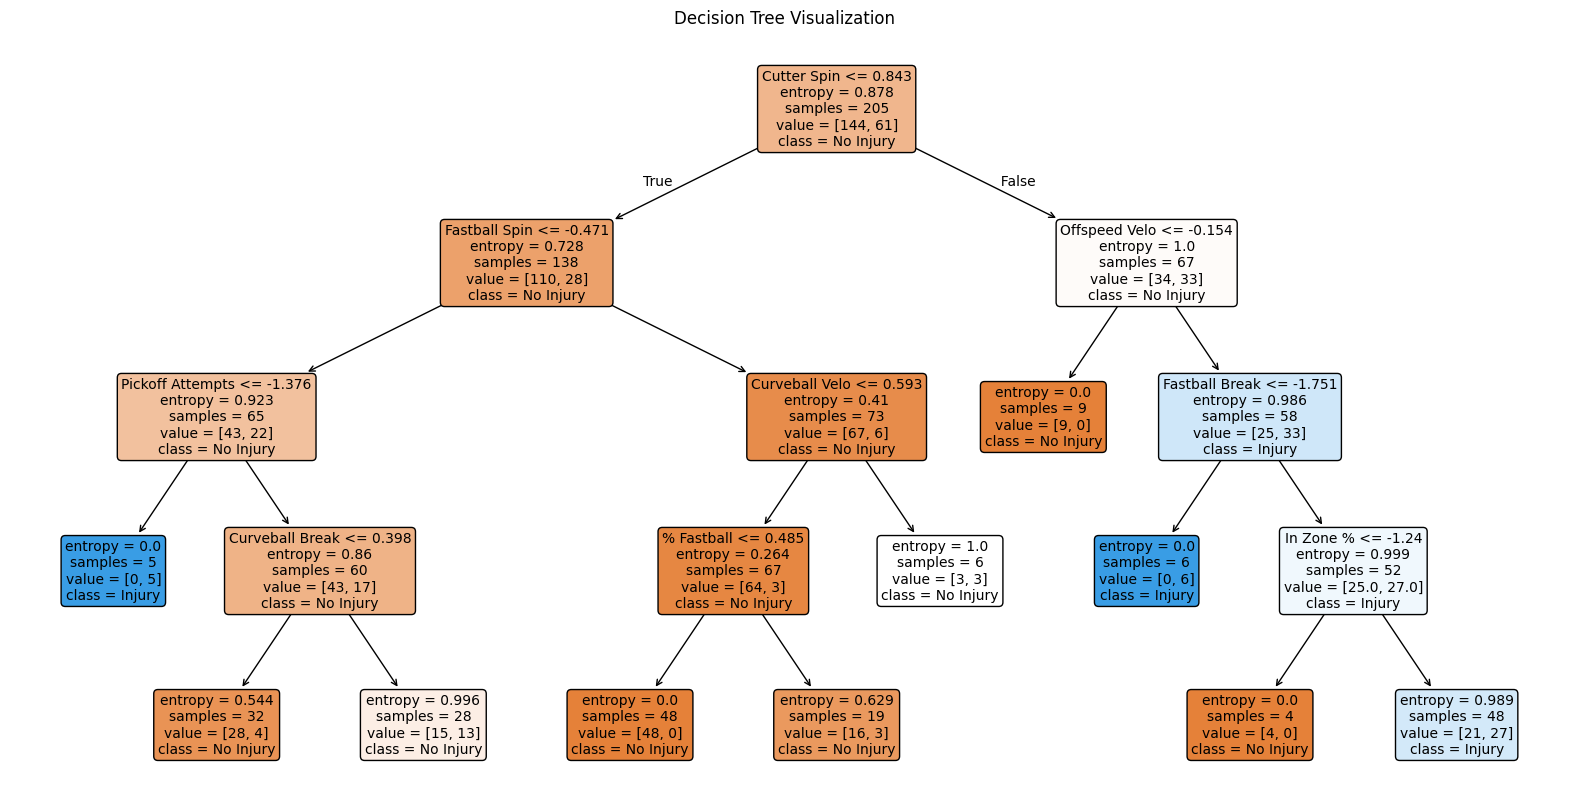

In [43]:
# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=["No Injury", "Injury"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree Visualization")
plt.show()

In [45]:
# Training XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predicting on validation set
y_val_pred = xgb_model.predict(X_val_scaled)
y_val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("XGBoost Performance on Validation Set:")
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

XGBoost Performance on Validation Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78        48
           1       0.43      0.30      0.35        20

    accuracy                           0.68        68
   macro avg       0.58      0.57      0.57        68
weighted avg       0.65      0.68      0.66        68

ROC AUC Score: 0.6151041666666667


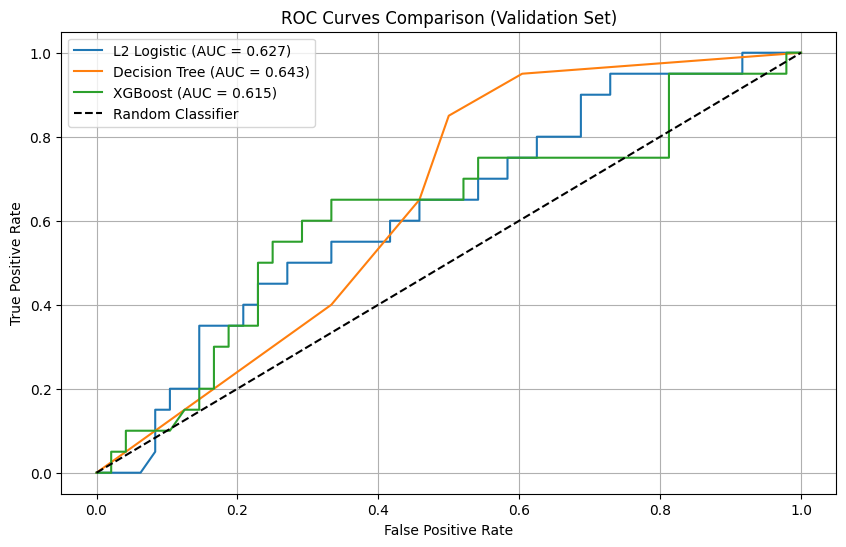

In [46]:
# Get prediction probabilities for all models
val_scores = {
    "L2 Logistic": final_logreg.predict_proba(X_val_scaled)[:, 1],
    "Decision Tree": dt.predict_proba(X_val_scaled)[:, 1],
    "XGBoost": xgb_model.predict_proba(X_val_scaled)[:, 1]
}

# Plot ROC Curve
plt.figure(figsize=(10,6))

for name, probas in val_scores.items():
    fpr, tpr, _ = roc_curve(y_val, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")


# Plot random classifier line
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

#### Final Models (Decision Tree Performed best)

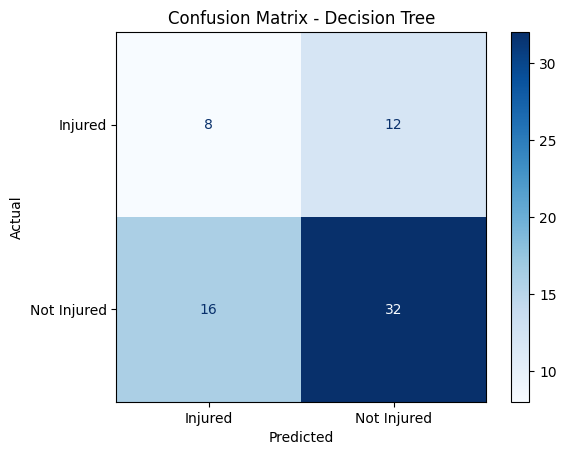

In [47]:
# Predictions from Decision Tree model
dt_preds = dt.predict(X_val_scaled)
dt_proba = dt.predict_proba(X_val_scaled)[:, 1]

# Confusion Matrix (formatting for "Injured" as positive class)
cm = confusion_matrix(y_val, dt_preds)
cm = np.array([[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]])  # [[TP, FN], [FP, TN]]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Injured", "Not Injured"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(False)
plt.show()